# 15wk-1: (강화학습) – LunarLander

최규빈  
2025-06-14

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/15wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-wRrm_RgJ30iOUKf8q-S6hP&si=JJC7LNK2zUvB275J>

# 2. Imports

> **Note**
>
> *코랩사용자는 아래코드 실행후 실습할것 *
>
> ``` python
> !pip install swig
> !pip install gymnasium[box2d]
> ```
>
> *학과서버사용자는 가상환경에서 아래를 설치*
>
> ``` bash
> conda install conda-forge::gymnasium-box2d 
> ```

In [66]:
import gymnasium as gym
#--#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import IPython
#--#
import collections
import random
#--#
import torch

In [67]:
def show(imgs,jump=10):
    imgs = imgs[::jump]
    fig = plt.Figure()
    ax = fig.subplots()
    def update(i):
        ax.imshow(imgs[i])
    ani = FuncAnimation(fig,update,frames=len(imgs))
    display(IPython.display.HTML(ani.to_jshtml()))

# 3. 예비학습

`-` `random.sample()`의 용법을 살펴보자.

`# 예시1`

In [68]:
random.sample([1,2,3,4,5],2)

`# 예시2`

In [69]:
s = [[0,0], [0,2], [3,2]]
a = [0,1,2]
memory = list(zip(s,a))
random.sample(memory,2)

# 4. env: LunarLander

`-` ref: <https://gymnasium.farama.org/environments/box2d/lunar_lander/>

`-` Lunar Lander: 요약

**Observation Space (State Space)** – 8개의 변수

1.  착륙선의 x 좌표
2.  착륙선의 y 좌표
3.  착륙선의 x 속도
4.  착륙선의 y 속도
5.  착륙선의 각도
6.  착륙선의 각속도
7.  왼쪽 다리가 땅에 닿아있는지 여부 (1 또는 0)
8.  오른쪽 다리가 땅에 닿아있는지 여부 (1 또는 0)

**Action Space** – 4개의 변수

1.  {0 : 아무 행동도 하지 않음}
2.  {1 : 왼쪽 엔진 발사 (오른쪽으로 기울임)}
3.  {2 : 메인 엔진 발사 (위로 밀어 올림)}
4.  {3 : 오른쪽 엔진 발사 (왼쪽으로 기울임)}

**Reward**

-   **거리 보상**: 착륙 패드에 가까울수록 보상 증가
-   **속도 보상**: 속도가 낮을수록 보상 증가
-   **각도 보상**: 각도가 수직에 가까울수록 보상 증가
-   **착륙 다리 보상**: 다리가 착륙 패드에 닿으면 보상
-   **연료 사용 패널티**: 엔진 사용 시 패널티
-   **안전한 착륙 보상**: 안정적으로 착륙 시 큰 보상 (+100~+140)
-   **충돌 패널티**: 착륙 패드 이외의 장소에 충돌 시 패널티 (-100)

`-` 환경생성

In [70]:
env = gym.make("LunarLander-v3", render_mode = "rgb_array")
env 

`-` state_space

In [71]:
env.observation_space.sample()

-   8개의 숫자가 포함된 array가 나옴
-   이 8개의 숫자는 각각 상태를 의미함

`-` action_space

In [72]:
env.action_space.sample()

-   0,1,2,3 중 하나가 랜덤으로 뽑힘

`-` env.reset()

In [73]:
env.reset()

`-` env.render()

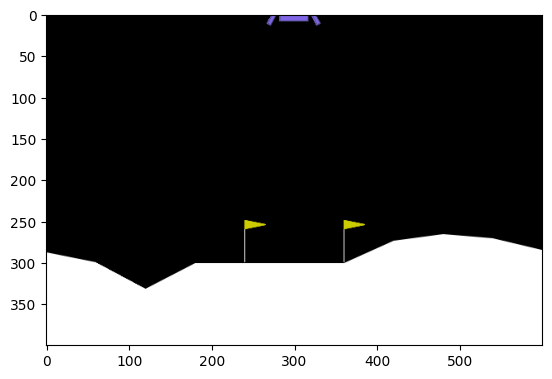

In [74]:
plt.imshow(env.render())

`-` env.step

In [75]:
env.step??

-   리턴되는 값은 `observation`, `reward`, `terminated`, `truncated`,
    `info`
-   우리가 쓰는 값은 `observation`, `reward`, `terminated`, `truncated`

`-` play

*첫시작화면*

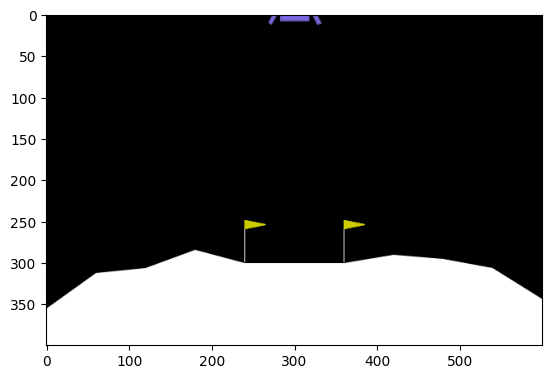

In [76]:
env.reset()
plt.imshow(env.render())

*플레이해보자*

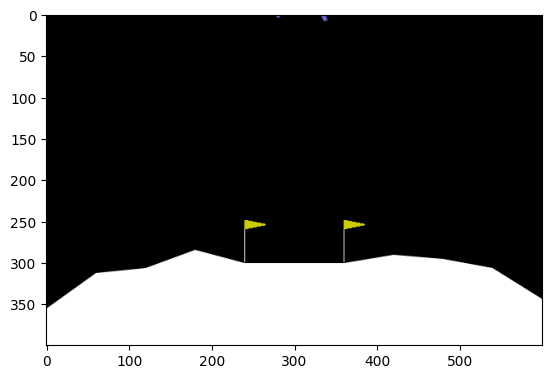

In [77]:
for _ in range(5):
    env.step(0) 
    env.step(3) 
plt.imshow(env.render())

# 5. 시각화

In [78]:
state, _ = env.reset()
imgs = []
for t in range(500):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    imgs.append(env.render())
    state = next_state 
    if terminated or truncated:
        break

In [79]:
show(imgs)

# 6. `RandomAgent`

In [80]:
class RandomAgent:
    def __init__(self):
        self.action_spcae = gym.spaces.Discrete(4)
        self.n_experieces = 0 
        #---#
        self.state = None 
        self.action = None 
        self.reward = None 
        self.next_state = None 
        self.terminated = None 
        #---#
        self.states = collections.deque(maxlen = 50000)
        self.actions = collections.deque(maxlen = 50000)
        self.rewards = collections.deque(maxlen = 50000)
        self.next_states = collections.deque(maxlen = 50000)
        self.terminations = collections.deque(maxlen = 50000)
    def act(self):
        self.action = self.action_spcae.sample()
    def learn(self):
        pass 
    def save_experience(self):
        self.states.append(torch.tensor(self.state))
        self.actions.append(self.action)
        self.rewards.append(self.reward)
        self.next_states.append(torch.tensor(self.next_state))
        self.terminations.append(self.terminated)
        self.n_experieces = self.n_experieces+1

In [81]:
env = gym.make("LunarLander-v3", render_mode = "rgb_array")
player = RandomAgent()
player.state,_ = env.reset()
for e in range(1,101):
    while True:
        # step1
        player.act()
        # step2
        player.next_state, player.reward, player.terminated, player.truncated, _ = env.step(player.action)
        # step3
        player.save_experience()
        player.learn()
        # step4 
        if player.terminated or player.truncated: 
            player.state, _ = env.reset()
            break 
        else: 
            player.state = player.next_state

# 7. `q_net`

In [82]:
# 이제 우리가 할것: q_table --> action 을 결정해야함. 

# 4x4 그리드 -- 복습 
# q_table[상태] = [행동0을했을때 품질, 행동1을했을때품질, 행동2를했을때품질, 행동3을했을때품질]  
# 행동 = argmax(q_talbe[상태])

# 루나랜더 -- 오늘 할것 
# q_net[8개의숫자] = [행동0을했을때 품질, 행동1을했을때품질, 행동2를했을때품질, 행동3을했을때품질] # 결국 숫자8개를 숫자4개로 만들어주는 적당한 q_net을 구성
# 행동 = argmax(q_net[8개의숫자])

`-` 전략: 4x4에서 `q_table`에 대응하는 뭔가가 있으면 된다. 그런데
`q_table`와 같이 테이블 형식으로는 힘들것 같다. $\to$ `q_net`를 만들자.

-   4x4 grid: 상태공간의 차원은 2차원이며 가질수 있는 값은 16개, 각
    상태공간에서 할수 있는 행동이 4개 -\> 총 16\*4의 경우의 수에 대한
    reward만 조사하면 되었음
-   LunarLander: 상태공간의 차원은 8차원이지만 가질수 있는 값의 범위는
    무한대 -\> 무수히 많은 경우에 대한 reward 값을 조사하는건 현실적으로
    불가능

*상황*

In [83]:
state = player.states[100]
action = player.actions[100]
reward = player.rewards[100]
next_state = player.next_states[100]
terminated = player.terminations[100]

`1`. `q_net`

In [84]:
player.q_net = torch.nn.Sequential(
    torch.nn.Linear(8,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,4)
)

In [85]:
player.q_net(state)

-   8개의 숫자가 들어가서 4개의 숫자가 나옴

`2`. `q_hat`

In [86]:
q_hat = player.q_net(state)[action]

`3`. `q` ($q = r + 0.99 \times {\tt future}$)

In [87]:
if terminated: 
    q = reward # q는 꼬리표가 없는 숫자 
else: 
    future = player.q_net(next_state).max().data # future에 꼬리표가 있으면 q에도 꼬리표가 생기므로 꼬리표 제거 
    q = reward + 0.99 * future # q는 꼬리표가 없는 숫자 

`4`. `q_hat` 을 점점 `q` 와 비슷하게 만드는 과정 = `player.q_net`를
학습하는 과정

In [88]:
# loss = (q_hat - q)**2
# loss를 점차 줄이면됨

In [89]:
player.optimizr = torch.optim.Adam(player.q_net.parameters())
for epoc in range(5):
    memory = list(zip(player.states, player.actions, player.rewards, player.next_states, player.terminations))
    mini_batch = random.sample(memory,64)
    # step1-2 
    loss = 0
    for s,a,r,ss,tmd in mini_batch:
        q_hat = player.q_net(s)[a]
        if tmd: 
            q = r 
        else: 
            future = player.q_net(ss).max().data 
            q = r + 0.99 * future
        loss = loss + (q_hat-q)**2
    loss = loss / 64
    # step3
    loss.backward()
    # step4 
    player.optimizr.step()
    player.optimizr.zero_grad()

`5`. 행동..?

In [90]:
# 이전에는 아래와 같은 방식
## 1. 특정 시점 이전에는 계속 랜덤액션만
## 2. 특정 시점 이후에는 계속 q_table에서 도출되는 행동만 
# 이번에는 아래와 같이 해보자. 
## 1. 처음에는 랜덤액션
## 2. 점차 에피소드가 지날수록, q_net에서 근거한 행동만

In [91]:
player.eps = 0.5 
if random.random() < player.eps: 
    player.action = player.action_spcae.sample()
else:
    state = torch.tensor(player.state)
    player.action = player.q_net(state).argmax().item()

In [92]:
# 다음에피소드에서는 아래와 같이 확률을 조금 낮게 
player.eps = player.eps* 0.99 

# 8. Agent

In [93]:
class Agent(RandomAgent):
    def __init__(self):
        super().__init__()
        self.eps = 1.0 
        self.q_net = torch.nn.Sequential(
            torch.nn.Linear(8,512),
            torch.nn.ReLU(),
            torch.nn.Linear(512,512),
            torch.nn.ReLU(),
            torch.nn.Linear(512,512),
            torch.nn.ReLU(),    
            torch.nn.Linear(512,4)
        )
        self.optimizr = torch.optim.Adam(self.q_net.parameters(),lr=0.0001)
    def act(self):
        if random.random() < self.eps: 
            self.action = self.action_spcae.sample()
        else:
            state = torch.tensor(self.state)
            # prob = torch.nn.functional.softmax(self.q_net(state).data,dim=0)
            # self.action =  torch.multinomial(prob, num_samples=1).item()
            self.action =  self.q_net(state).data.argmax().item()
    def learn(self):
        if self.n_experieces > 16:
            for epoc in range(1):
                memory = list(zip(self.states, self.actions, self.rewards, self.next_states, self.terminations))
                mini_batch = random.sample(memory,16)
                # step1-2 
                loss = 0
                for s,a,r,ss,tmd in mini_batch:
                    q_hat = self.q_net(s)[a]
                    if tmd: 
                        q = r 
                    else: 
                        future = self.q_net(ss).max().data 
                        q = r + 0.99 * future
                    loss = loss + (q_hat-q)**2
                loss = loss / 16
                # step3
                loss.backward()
                # step4 
                self.optimizr.step()
                self.optimizr.zero_grad()        

# 9. Solve

In [95]:
env = gym.make("LunarLander-v3", render_mode = "rgb_array")
player = Agent()
player.state, _ = env.reset()
score = 0
playtime = 0
scores = [] 
playtimes = []
player.eps = 1.0
#---#
for e in range(1,5001):
    #---에피소드시작---#
    while True:
        #step1
        player.act()
        #step2
        player.next_state, player.reward, player.terminated, player.truncated, _ = env.step(player.action)
        #step3
        player.save_experience()
        player.learn()
        #step4
        if player.terminated or player.truncated:
            score = score + player.reward
            scores.append(score)
            score = 0
            playtimes.append(playtime)
            playtime = 0
            player.state, _ = env.reset()
            break
        else: 
            score = score + player.reward
            playtime = playtime + 1 
            player.state = player.next_state
    #---에피소드끝---#
    player.eps = player.eps * 0.995
    log_freq = 50
    if (e % log_freq) ==0:
        print(
            f"에피소드: {e}\t",
            f"경험: {player.n_experieces}\t",
            f"점수: {np.mean(scores[-log_freq:]):.2f}\t",
            f"게임시간: {np.mean(playtimes[-log_freq:]):.2f}\t",
            f"돌발행동: {player.eps:.2f}\t",
        )
    if np.mean(scores[-100:]) > 200:
        print(f"--에피소드 {e} 에서 루나랜더 클리어(2025.06.24. ver)--")
        break 

에피소드: 50     경험: 5089    점수: -168.94     게임시간: 100.78    돌발행동: 0.78 
에피소드: 100    경험: 11872   점수: -131.51     게임시간: 134.66    돌발행동: 0.61 
에피소드: 150    경험: 22717   점수: -75.67  게임시간: 215.90    돌발행동: 0.47 
에피소드: 200    경험: 48501   점수: -95.67  게임시간: 514.68    돌발행동: 0.37 
에피소드: 250    경험: 87500   점수: -11.95  게임시간: 778.98    돌발행동: 0.29 
에피소드: 300    경험: 120529  점수: 85.72   게임시간: 659.58    돌발행동: 0.22 
에피소드: 350    경험: 154720  점수: 132.57  게임시간: 682.82    돌발행동: 0.17 
에피소드: 400    경험: 180474  점수: 188.14  게임시간: 514.08    돌발행동: 0.13 
--에피소드 440 에서 루나랜더 클리어(2025.06.24. ver)--

In [100]:
# torch.save(player.q_net.state_dict(), 'q_net.pth')

***아래코드 실행하면 제가 실습에 사용한 파일 받아올수있어요***

``` python
!wget https://github.com/guebin/DL2025/raw/main/posts/q_net.pth
```

------------------------------------------------------------------------

In [101]:
player_dummy = Agent()
player_dummy.q_net.load_state_dict(
    torch.load("q_net.pth")
)
player_dummy.state, _ = env.reset()
imgs = []

In [102]:
player_dummy.eps = 0 
while True:
    player_dummy.act()
    player_dummy.next_state, player_dummy.reward, player_dummy.terminated, player_dummy.truncated, _ = env.step(player_dummy.action)
    imgs.append(env.render())
    if player_dummy.terminated or player_dummy.truncated:
        break
    else:
        player_dummy.state = player_dummy.next_state

In [103]:
show(imgs)